# Adversarial Training Using the Fast Gradient Sign Method (FGSM)

In this example we will demonstrate how to train a model to resist adversarial attacks constructed using the Fast Gradient Sign Method. For more background on adversarial attacks, visit: https://arxiv.org/abs/1412.6572

## Import the required libraries

In [1]:
import tempfile
import os

import numpy as np

import fastestimator as fe
from fastestimator.architecture.tensorflow import LeNet
from fastestimator.backend import to_tensor, argmax, to_number
from fastestimator.dataset.data import cifar10
from fastestimator.op.numpyop.meta import Sometimes
from fastestimator.op.numpyop.multivariate import HorizontalFlip
from fastestimator.op.numpyop.univariate import CoarseDropout, Normalize, Onehot
from fastestimator.op.tensorop import Average
from fastestimator.op.tensorop.gradient import Watch, FGSM
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.trace.io import BestModelSaver
from fastestimator.trace.metric import Accuracy
from fastestimator.util import ImgData

In [2]:
# training parameters
epsilon=0.04  # The strength of the adversarial attack
epochs=10
batch_size=50
max_train_steps_per_epoch=None
max_eval_steps_per_epoch=None
save_dir=tempfile.mkdtemp()

## Step 1 - Data and `Pipeline` preparation
In this step, we will load Cifar10 training and validation datasets and prepare FastEstimator's pipeline.

### Load dataset 
We use fastestimator API to load the Cifar10 dataset and get the test set by splitting 50% evaluation set. 

In [3]:
from fastestimator.dataset.data import cifar10

train_data, eval_data = cifar10.load_data()
test_data = eval_data.split(0.5)

### Prepare the `Pipeline`
We will use a simple pipeline that just normalizes the images

In [4]:
pipeline = fe.Pipeline(
        train_data=train_data,
        eval_data=eval_data,
        test_data=test_data,
        batch_size=batch_size,
        ops=[
            Normalize(inputs="x", outputs="x", mean=(0.4914, 0.4822, 0.4465), std=(0.2471, 0.2435, 0.2616))
        ])

## Step 2 - `Network` construction

### Model Construction
Here we will leverage the LeNet implementation built in to FastEstimator

In [5]:
model = fe.build(model_fn=lambda: LeNet(input_shape=(32, 32, 3)), optimizer_fn="adam", model_names="adv_model")

### `Network` defintion
This is where the adversarial attack will be implemented. To perform an FGSM attack, we first need to monitor gradients with respect to the input image. This can be accomplished in FastEstimator using the `Watch` TensorOp. We then will run the model forward once, compute the loss, and then pass the loss value into the `FGSM` tensorOp in order to create an adversarial image. We will then run the adversarial image through the model, compute the loss again, and average the two results together in order to update the model. 

In [6]:
network = fe.Network(ops=[
        Watch(inputs="x"),
        ModelOp(model=model, inputs="x", outputs="y_pred"),
        CrossEntropy(inputs=("y_pred", "y"), outputs="base_ce"),
        FGSM(data="x", loss="base_ce", outputs="x_adverse", epsilon=epsilon),
        ModelOp(model=model, inputs="x_adverse", outputs="y_pred_adv"),
        CrossEntropy(inputs=("y_pred_adv", "y"), outputs="adv_ce"),
        Average(inputs=("base_ce", "adv_ce"), outputs="avg_ce"),
        UpdateOp(model=model, loss_name="avg_ce")
    ])

## Step 3 - `Estimator` definition and training
In this step, we define the `Estimator` to connect the `Network` with `Pipeline` and set the `traces` which will compute accuracy (Accuracy), and save the best model (BestModelSaver) along the way. We will compute accuracy both with respect to the clean input images ('clean accuracy') as well as with respect to the adversarial input images ('adversarial accuracy'). At the end, we use `Estimator.fit` to trigger the training.

In [7]:
traces = [
    Accuracy(true_key="y", pred_key="y_pred", output_name="clean_accuracy"),
    Accuracy(true_key="y", pred_key="y_pred_adv", output_name="adversarial_accuracy"),
    BestModelSaver(model=model, save_dir=save_dir, metric="base_ce", save_best_mode="min"),
]
estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=epochs,
                         traces=traces,
                         max_train_steps_per_epoch=max_train_steps_per_epoch,
                         max_eval_steps_per_epoch=max_eval_steps_per_epoch,
                         monitor_names=["base_ce", "adv_ce"],
                         log_steps=1000)

In [8]:
estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; adv_model_lr: 0.001; 
FastEstimator-Train: step: 1; adv_ce: 2.4914558; base_ce: 2.3271847; avg_ce: 2.4093204; 
FastEstimator-Train: step: 1000; adv_ce: 1.6937535; base_ce: 1.29402; avg_ce: 1.4938867; steps/sec: 21.3; 
FastEstimator-Train: step: 1000; epoch: 1; epoch_time: 50.27 sec; 
FastEstimator-ModelSaver: saved model to /var/folders/lx/drkxftt117gblvgsp1p39rlc0000gn/T/tmpddgcxg9j/adv_model_best_base_ce.h5
FastEstimator-Eval: step: 1000; epoch: 1; avg_ce: 1.4610062; base_ce: 1.2934717; adv_ce: 1.6285404; min_avg_ce: 1.4610

## Model Testing
Let's start by re-loading the weights from the best model, since the model may have overfit during training


In [9]:
model.load_weights(os.path.join(save_dir, "adv_model_best_base_ce.h5"))

In [10]:
estimator.test()

FastEstimator-Test: epoch: 10; clean_accuracy: 0.6932; adversarial_accuracy: 0.4674; 


In spite of our training the network using adversarially crafted images, the adversarial attack is still effective at reducing the accuracy of the network. This does not, however, mean that the efforts were wasted. 

# Comparison vs Network without Adversarial Training
To see whether training using adversarial hardening was actually useful, we will compare it to a network which is trained without considering any adversarial images. The setup will be similar to before, but we will only use the adversarial images for evaluation purposes and so the second `CrossEntropy` Op as well as the `Average` Op can be omitted.  

In [11]:
clean_model = fe.build(model_fn=lambda: LeNet(input_shape=(32, 32, 3)), optimizer_fn="adam", model_names="clean_model")
clean_network = fe.Network(ops=[
        Watch(inputs="x"),
        ModelOp(model=clean_model, inputs="x", outputs="y_pred"),
        CrossEntropy(inputs=("y_pred", "y"), outputs="base_ce"),
        FGSM(data="x", loss="base_ce", outputs="x_adverse", epsilon=epsilon, mode="!train"),
        ModelOp(model=clean_model, inputs="x_adverse", outputs="y_pred_adv", mode="!train"),
        UpdateOp(model=clean_model, loss_name="base_ce")
    ])
clean_traces = [
    Accuracy(true_key="y", pred_key="y_pred", output_name="clean_accuracy"),
    Accuracy(true_key="y", pred_key="y_pred_adv", output_name="adversarial_accuracy"),
    BestModelSaver(model=clean_model, save_dir=save_dir, metric="base_ce", save_best_mode="min"),
]
clean_estimator = fe.Estimator(pipeline=pipeline,
                         network=clean_network,
                         epochs=epochs,
                         traces=clean_traces,
                         max_train_steps_per_epoch=max_train_steps_per_epoch,
                         max_eval_steps_per_epoch=max_eval_steps_per_epoch,
                         log_steps=1000)
clean_estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; clean_model_lr: 0.001; 
FastEstimator-Train: step: 1; base_ce: 2.3439963; 
FastEstimator-Train: step: 1000; base_ce: 1.3183937; steps/sec: 76.8; 
FastEstimator-Train: step: 1000; epoch: 1; epoch_time: 13.41 sec; 
FastEstimator-ModelSaver: saved model to /var/folders/lx/drkxftt117gblvgsp1p39rlc0000gn/T/tmpddgcxg9j/clean_model_best_base_ce.h5
FastEstimator-Eval: step: 1000; epoch: 1; base_ce: 1.152839; min_base_ce: 1.152839; since_best: 0; clean_accuracy: 0.5848; adversarial_accuracy: 0.283; 
FastEstimator-Train: step: 2000; ba

As before, we will reload the best weights and the test the model

In [12]:
clean_model.load_weights(os.path.join(save_dir, "clean_model_best_base_ce.h5"))

In [13]:
print("Normal Network:")
normal_results = clean_estimator.test("normal")
print("The whitebox FGSM attack reduced accuracy by {:.2f}".format(list(normal_results.history['test']['clean_accuracy'].values())[0] - list(normal_results.history['test']['adversarial_accuracy'].values())[0]))
print("-----------")
print("Adversarially Trained Network:")
adversarial_results = estimator.test("adversarial")
print("The whitebox FGSM attack reduced accuracy by {:.2f}".format(list(adversarial_results.history['test']['clean_accuracy'].values())[0] - list(adversarial_results.history['test']['adversarial_accuracy'].values())[0]))
print("-----------")

Normal Network:
FastEstimator-Test: epoch: 10; clean_accuracy: 0.7318; adversarial_accuracy: 0.2434; 
The whitebox FGSM attack reduced accuracy by 0.49
-----------
Adversarially Trained Network:
FastEstimator-Test: epoch: 10; clean_accuracy: 0.6932; adversarial_accuracy: 0.4674; 
The whitebox FGSM attack reduced accuracy by 0.23
-----------


As we can see, the normal network is significantly less robust against adversarial attacks than the one which was trained to resist them. The downside is that the adversarial network requires more epochs of training to converge, and the training steps take about twice as long since they require two forward pass operations. It is also interesting to note that as the regular model was training, it actually saw progressively worse adversarial accuracy. This may be an indication that the network is developing very brittle decision boundaries. 

## Visualizing Adversarial Samples
Lets visualize some images generated by these adversarial attacks to make sure that everything is working as we would expect. The first step is to get some sample data from the pipeline:

In [14]:
class_dictionary = {
    0: "airplane", 1: "car", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"
}
batch = pipeline.get_results(mode="test")

Now let's run our sample data through the network and then visualize the results

In [15]:
batch = clean_network.transform(batch, mode="test")

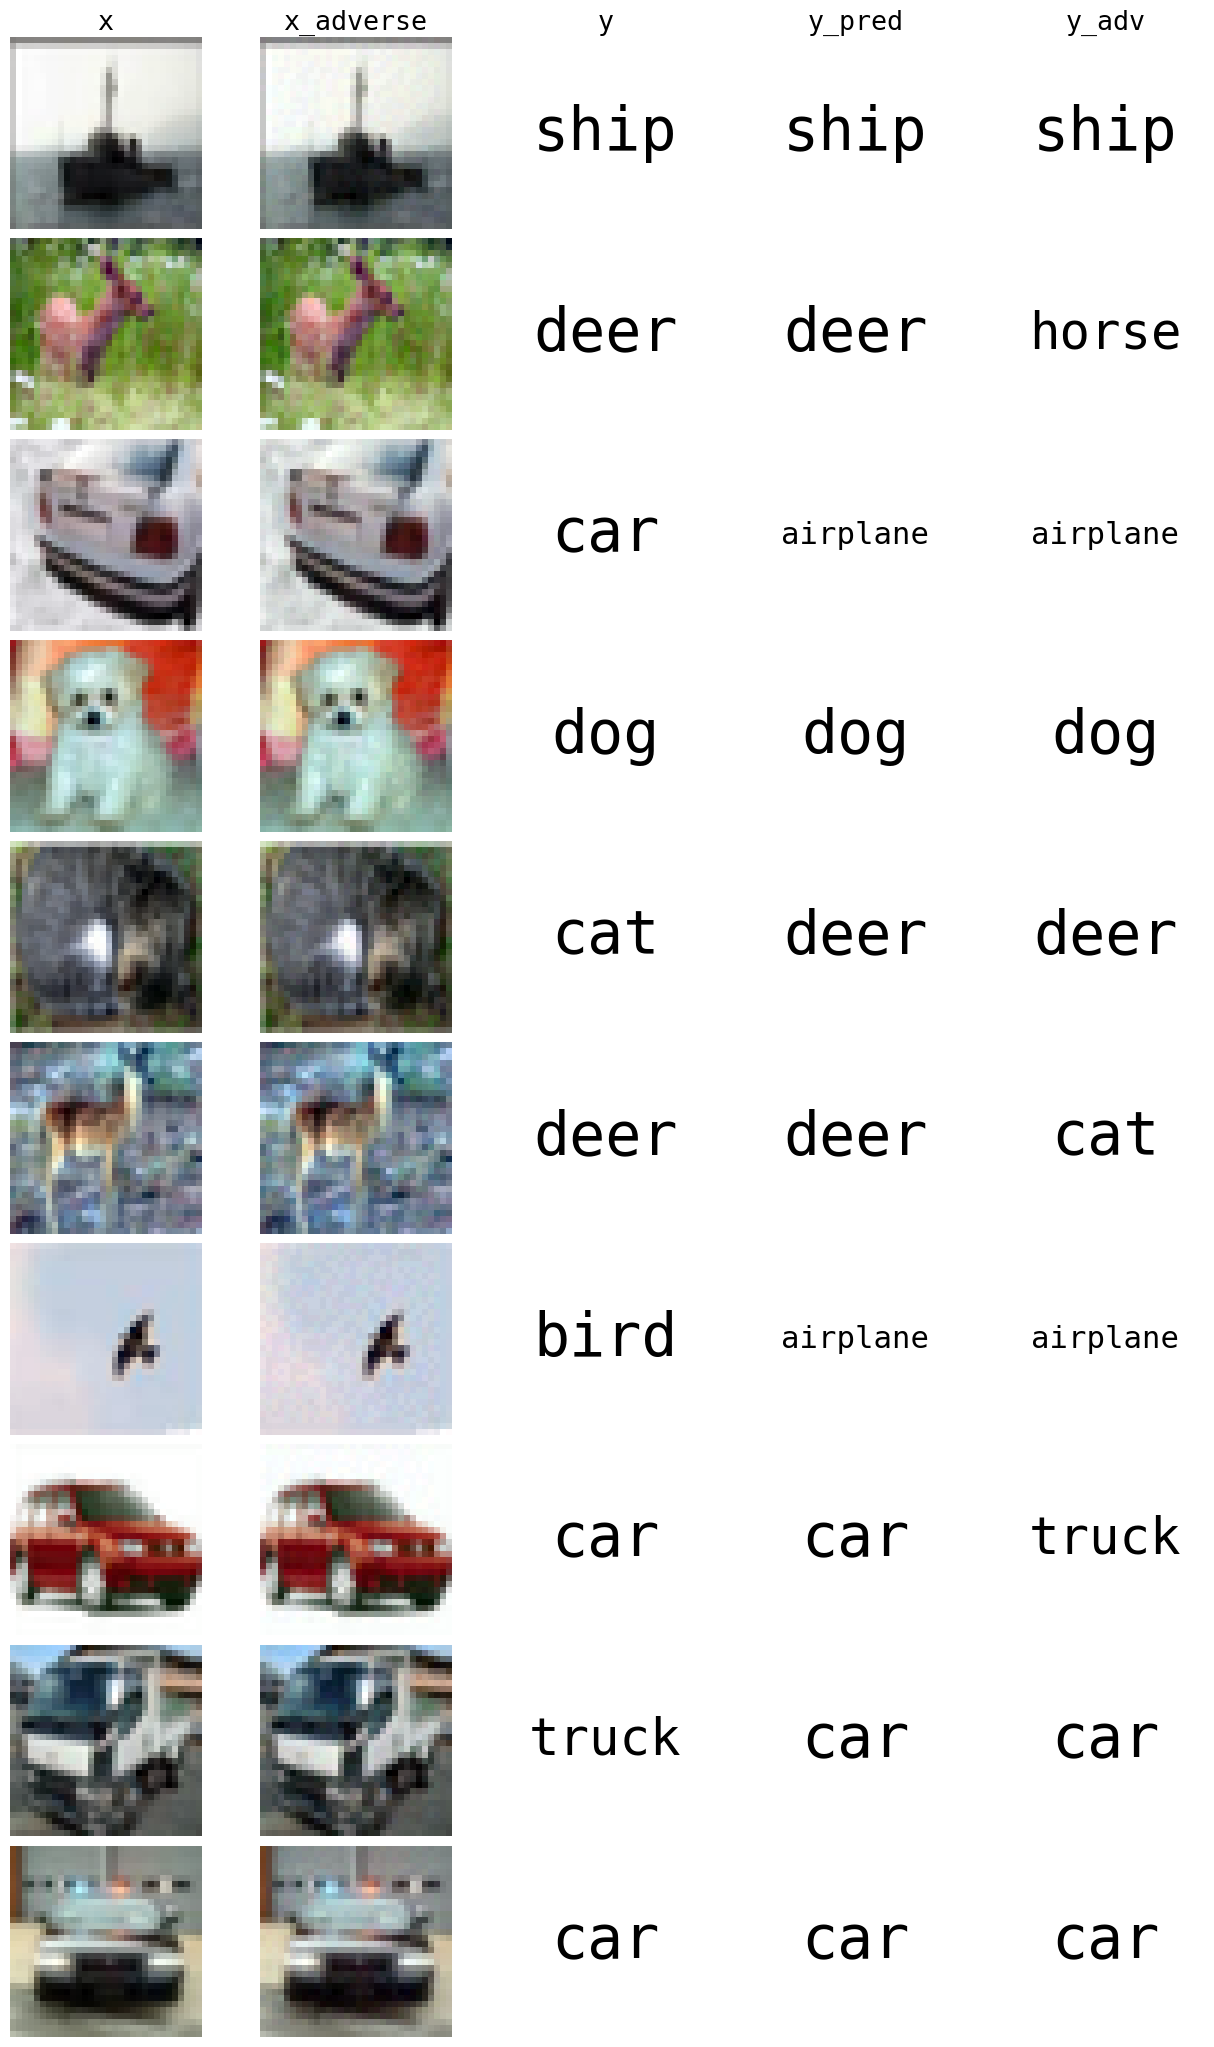

In [16]:
n_samples = 10
y = np.array([class_dictionary[clazz.item()] for clazz in to_number(batch["y"][0:n_samples])])
y_pred = np.array([class_dictionary[clazz.item()] for clazz in to_number(argmax(batch["y_pred"], axis=1)[0:n_samples])])
y_adv = np.array([class_dictionary[clazz.item()] for clazz in to_number(argmax(batch["y_pred_adv"], axis=1)[0:n_samples])])
img = ImgData(x=batch["x"][0:n_samples], x_adverse=batch["x_adverse"][0:n_samples], y=y, y_pred=y_pred, y_adv=y_adv)
fig = img.paint_figure()

As you can see, the adversarial images appear very similar to the unmodified images, and yet they are often able to modify the class predictions of the network. Note that if a network's prediction is already wrong, the attack is unlikely to change the incorrect prediction, but rather to increase the model's confidence in its incorrect prediction. 